# Initial Data Exploration

This notebook performs a first-pass exploration of the stock index dataset.

We will:
- Load the raw and processed files
- Inspect schema and data quality
- Generate basic descriptive statistics
- Visualize trends for selected indices

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)

In [ ]:
project_root = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
data_dir = project_root / "data"

candidate_dirs = [
    data_dir,
    data_dir / "StockExchangeData",
]

def resolve_csv(filename: str) -> Path:
    for folder in candidate_dirs:
        candidate = folder / filename
        if candidate.exists():
            return candidate
    searched = "\n".join(str(folder / filename) for folder in candidate_dirs)
    raise FileNotFoundError(f"Could not find {filename}. Searched:\n{searched}")

index_processed_path = resolve_csv("indexData.csv")
index_info_path = resolve_csv("indexInfo.csv")
index_processed_path = resolve_csv("indexProcessed.csv")

print("Project root:", project_root)
print("indexData path:", index_data_path)
print("indexInfo path:", index_info_path)
print("indexProcessed path:", index_processed_path)

Project root: c:\GitHub\global-stock-index-ml-classification
indexData path: c:\GitHub\global-stock-index-ml-classification\data\StockExchangeData\indexData.csv
indexInfo path: c:\GitHub\global-stock-index-ml-classification\data\StockExchangeData\indexInfo.csv
indexProcessed path: c:\GitHub\global-stock-index-ml-classification\data\StockExchangeData\indexProcessed.csv


In [11]:
index_processed = pd.read_csv(index_processed_path)
print("index_processed shape:", index_processed.shape)

index_processed shape: (104224, 9)


## 1) Quick Preview

In [12]:
display(index_processed.head())

,Index,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
0,HSI,1986-12-31,2568.300049,2568.300049,2568.300049,2568.300049,2568.300049,0.0,333.879006
1,HSI,1987-01-02,2540.100098,2540.100098,2540.100098,2540.100098,2540.100098,0.0,330.213013
2,HSI,1987-01-05,2552.399902,2552.399902,2552.399902,2552.399902,2552.399902,0.0,331.811987
3,HSI,1987-01-06,2583.899902,2583.899902,2583.899902,2583.899902,2583.899902,0.0,335.906987
4,HSI,1987-01-07,2607.100098,2607.100098,2607.100098,2607.100098,2607.100098,0.0,338.923013


## 2) Schema and Missing Values

In [13]:
def summarize(df: pd.DataFrame, name: str) -> None:
    print(f"\n{name}")
    print("-" * len(name))
    display(df.dtypes.to_frame("dtype").T)
    nulls = df.isna().sum().sort_values(ascending=False)
    display(nulls[nulls > 0].to_frame("missing_count").head(20))

summarize(index_processed, "index_processed")


index_processed
---------------


,Index,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
dtype,str,str,float64,float64,float64,float64,float64,float64,float64


,missing_count


## 3) Time Coverage and Sample Trends

Detected date column: Date
Detected index/name column: Index
Detected value column: Close
Date range: 1965-01-05 00:00:00 to 2021-06-03 00:00:00


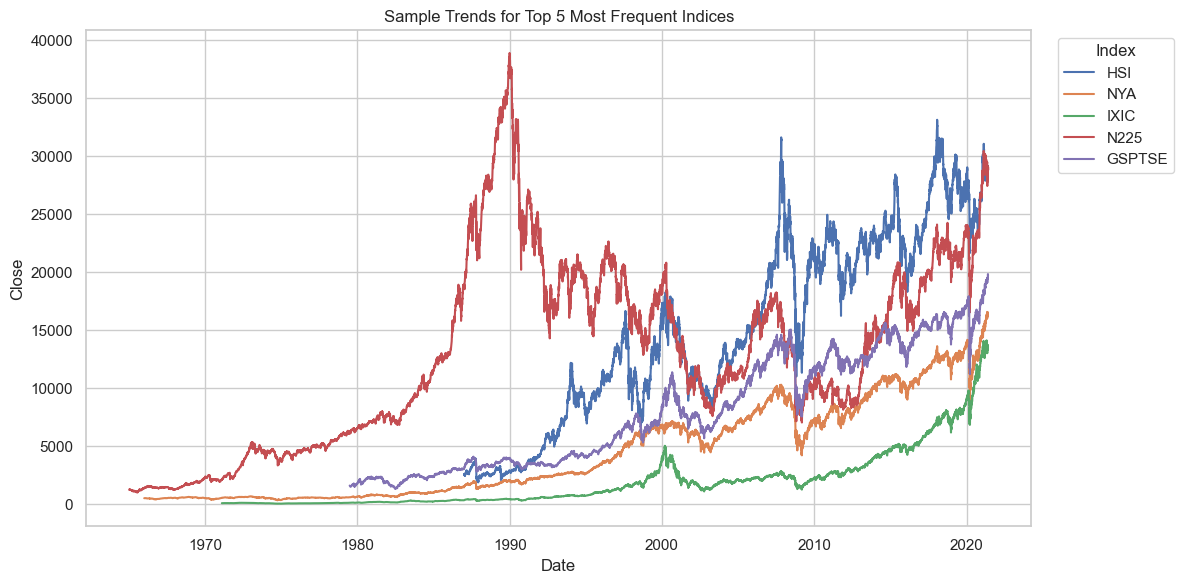

In [15]:
date_candidates = ["Date", "date", "Timestamp", "timestamp"]
name_candidates = ["Index", "index", "Name", "name", "IndexName", "index_name"]
value_candidates = ["Close", "close", "Adj Close", "adj_close", "Value", "value"]

def pick_column(columns, candidates):
    lower_map = {c.lower(): c for c in columns}
    for candidate in candidates:
        if candidate.lower() in lower_map:
            return lower_map[candidate.lower()]
    return None

date_col = pick_column(index_processed.columns, date_candidates)
name_col = pick_column(index_processed.columns, name_candidates)
value_col = pick_column(index_processed.columns, value_candidates)

print("Detected date column:", date_col)
print("Detected index/name column:", name_col)
print("Detected value column:", value_col)

if date_col is not None:
    index_processed[date_col] = pd.to_datetime(index_processed[date_col], errors="coerce")
    print("Date range:", index_processed[date_col].min(), "to", index_processed[date_col].max())

if all(col is not None for col in [date_col, name_col, value_col]):
    plot_df = index_processed[[date_col, name_col, value_col]].dropna().copy()
    top_indices = plot_df[name_col].value_counts().head(5).index
    plot_df = plot_df[plot_df[name_col].isin(top_indices)]

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=plot_df, x=date_col, y=value_col, hue=name_col)
    plt.title("Sample Trends for Top 5 Most Frequent Indices")
    plt.xlabel("Date")
    plt.ylabel(value_col)
    plt.legend(title=name_col, bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
else:
    print("Could not auto-detect plotting columns. Please set date_col, name_col, and value_col manually.")

## 4) Feature Correlation (`index_processed`)

Correlation is computed across numeric columns only.

,Open,High,Low,Close,Adj Close,Volume,CloseUSD
Open,1.000,1.000,1.000,1.000,1.000,0.129,0.188
High,1.000,1.000,1.000,1.000,1.000,0.129,0.188
Low,1.000,1.000,1.000,1.000,1.000,0.129,0.188
Close,1.000,1.000,1.000,1.000,1.000,0.129,0.188
Adj Close,1.000,1.000,1.000,1.000,1.000,0.129,0.188
Volume,0.129,0.129,0.129,0.129,0.129,1.000,0.506
CloseUSD,0.188,0.188,0.188,0.188,0.188,0.506,1.000


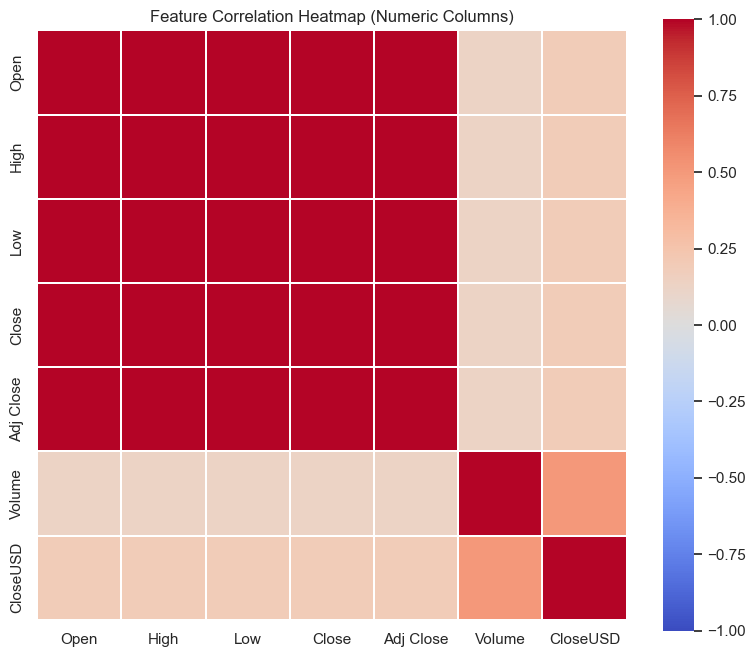

Top 10 strongest correlations (absolute):


correlation
Adj Close Close         1.000000
Close     Adj Close     1.000000
Low       Close         0.999958
Close     Low           0.999958
Low       Adj Close     0.999958
Adj Close Low           0.999958
Open      High          0.999958
High      Open          0.999958
          Adj Close     0.999954
Adj Close High          0.999954

In [16]:
numeric_df = index_processed.select_dtypes(include=[np.number]).copy()

if numeric_df.shape[1] < 2:
    print("Not enough numeric columns to compute correlation.")
else:
    corr_matrix = numeric_df.corr(numeric_only=True)
    display(corr_matrix.round(3))

    feature_count = corr_matrix.shape[0]
    fig_size = max(8, min(18, int(feature_count * 0.8)))

    plt.figure(figsize=(fig_size, fig_size))
    sns.heatmap(
        corr_matrix,
        cmap="coolwarm",
        center=0,
        vmin=-1,
        vmax=1,
        square=True,
        linewidths=0.3,
        cbar_kws={"shrink": 0.8}
    )
    plt.title("Feature Correlation Heatmap (Numeric Columns)")
    plt.tight_layout()
    plt.show()

    corr_pairs = (
        corr_matrix.where(~np.eye(corr_matrix.shape[0], dtype=bool))
        .stack()
        .sort_values(key=lambda s: s.abs(), ascending=False)
    )
    print("Top 10 strongest correlations (absolute):")
    display(corr_pairs.head(10).to_frame("correlation"))

## 4) Next Steps

- Check class/label balance in processed dataset for classification tasks
- Engineer lag/rolling features per index
- Split data with time-aware strategy before model training